# Homework 5

## Importing and Preprocessing Data

In [1]:
import json
import pandas as pd
data_file = open("Downloads/yelp_academic_dataset_review.json")
data = []
for line in data_file:
    data.append(json.loads(line))
checkin_df = pd.DataFrame(data)
data_file.close()

yelp_stars = checkin_df.stars.to_numpy()
yelp_text = checkin_df.text.to_numpy()

In [2]:
# subset of the data
yelpStars = yelp_stars[0:40000]

In [3]:
# subset of the data
yelpReviews = yelp_text[0:40000]

In [ ]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace

import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [5]:
# since stars is from range 1 - 5, needs to be transformed from 0-4
for i in range(len(yelpStars)):
    yelpStars[i] = yelpStars[i] - 1

In [6]:
# removing unnecessary characters from reviews
for i in range(len(yelpReviews)):
    new_string = yelpReviews[i].replace("\n", "")
    new_string1 = new_string.replace("\""," ")
    yelpReviews[i] = new_string

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
# splitting dataset into test, train, and validation
train_val_X, testX, train_val_Y, testY = train_test_split(yelpReviews, yelpStars, train_size=0.8, random_state=1)
trainX, valX, trainY, valY = train_test_split(train_val_X, train_val_Y, train_size=0.5, random_state=1)

## Bidirectional RNN

In [9]:
# create a TextVectorization layer to turn input string into a sequence of integers,
# each representing one token
maxTokens = 500
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)

vectorizeLayer.adapt(trainX)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(Bidirectional(SimpleRNN(64)))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add softmax classifier
model.add(Dense(5, activation = 'softmax'))


2022-12-09 20:24:03.097548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-09 20:24:03.098256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-09 20:24:03.266379: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M2


2022-12-09 20:24:03.392398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [10]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 100, 128)          64128     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              24704     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 97,413
Trainable params: 97,413
Non-traina

Epoch 1/3


2022-12-09 20:24:38.624123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.4441

2022-12-09 21:02:31.232453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 2432s 10s/step - loss: 1.3300 - accuracy: 0.4441 - val_loss: 1.1897 - val_accuracy: 0.4849
Epoch 2/3
250/250 [==============================] - 2224s 9s/step - loss: 1.1401 - accuracy: 0.5162 - val_loss: 1.1287 - val_accuracy: 0.5104
Epoch 3/3
250/250 [==============================] - 2231s 9s/step - loss: 1.0404 - accuracy: 0.5631 - val_loss: 1.1150 - val_accuracy: 0.5130


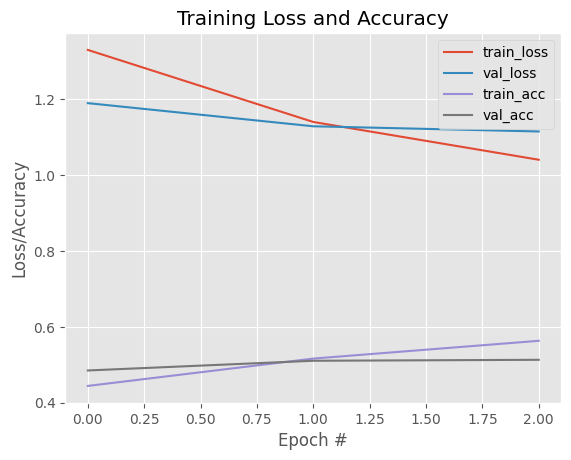

In [11]:
epochs = 3

H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = epochs, batch_size = 64)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [13]:
#testing model
model.evaluate(testX, testY)

2022-12-09 22:23:37.322258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 149s 595ms/step - loss: 1.1131 - accuracy: 0.5166


[1.113105058670044, 0.5166250467300415]

### Evaluatation of Written Review

In [16]:
print(model.predict(['While this movie series is usually great, I really disliked this sequel']))
# This review has 1 star

1/1 [==============================] - 1s 608ms/step
[[0.00774914 0.02588726 0.160317   0.575653   0.2303936 ]]


The model predicted the greatest possiblity of a 4-star rating while the actual rating was 1-star.

In [17]:
print(model.predict(['This movie was spectular! I loved the characters and the plot was so well thought out!']))
## This is a 5-star review

1/1 [==============================] - 1s 588ms/step
[[0.03256047 0.0281984  0.0908957  0.3949108  0.4534346 ]]


For this noticeably 5-star review, the model was able to correct predict the star rating on this particlar reviewl.

## Bidirectional GRU Network

In [34]:
maxTokens = 500
vectorizeLayer = TextVectorization(max_tokens = maxTokens,
                                   output_mode = 'int',
                                   output_sequence_length = 100)


vectorizeLayer.adapt(trainX)

model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
model.add(Embedding(maxTokens + 1, 128))

# add a fully-connected recurrent layer
model.add(GRU(64))

# add a dense layer
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# add softmax classifier
model.add(Dense(5, activation = 'softmax'))

2022-12-09 22:56:24.606786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [35]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 100, 128)          64128     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                      

Epoch 1/20


2022-12-09 22:56:26.999150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:56:27.085421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:56:27.354548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


499/500 [============================>.] - ETA: 0s - loss: 1.4117 - accuracy: 0.4383

2022-12-09 22:56:48.189277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-09 22:56:48.275806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 28s 54ms/step - loss: 1.4113 - accuracy: 0.4386 - val_loss: 1.3719 - val_accuracy: 0.4488
Epoch 2/20
500/500 [==============================] - 20s 40ms/step - loss: 1.3906 - accuracy: 0.4413 - val_loss: 1.3402 - val_accuracy: 0.4557
Epoch 3/20
500/500 [==============================] - 20s 40ms/step - loss: 1.3767 - accuracy: 0.4377 - val_loss: 1.5105 - val_accuracy: 0.4462
Epoch 4/20
500/500 [==============================] - 20s 40ms/step - loss: 1.3887 - accuracy: 0.4447 - val_loss: 1.3489 - val_accuracy: 0.4510
Epoch 5/20
500/500 [==============================] - 20s 41ms/step - loss: 1.3225 - accuracy: 0.4537 - val_loss: 1.2295 - val_accuracy: 0.4818
Epoch 6/20
500/500 [==============================] - 20s 40ms/step - loss: 1.2046 - accuracy: 0.4943 - val_loss: 1.1774 - val_accuracy: 0.4899
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 1.1834 - accuracy: 0.4921 - val_loss: 1.1413 - val_accuracy: 0.5046
Epo

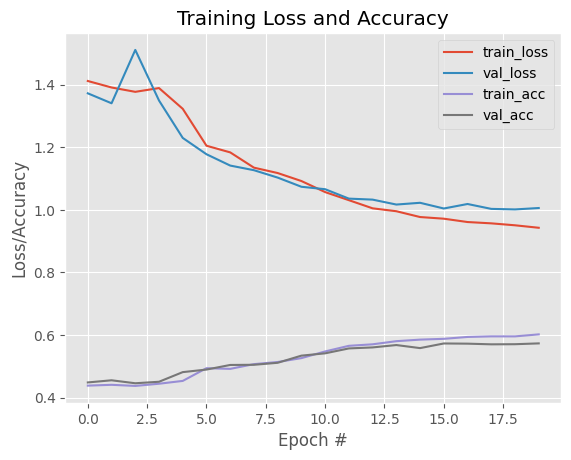

In [36]:
epochs = 20

H = model.fit(trainX, trainY, validation_data = (valX, valY), epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [37]:
# testing model
model.evaluate(testX, testY)

250/250 [==============================] - 3s 13ms/step - loss: 0.9907 - accuracy: 0.5769


[0.9907362461090088, 0.5768750309944153]

### Evaluatation of Written Review

In [45]:
print(model.predict(['While this movie series is usually great, I really disliked this sequel.']))
# This review has 1 star

1/1 [==============================] - 0s 32ms/step
[[0.00713622 0.01750159 0.07414225 0.38782534 0.5133946 ]]


In [44]:
print(model.predict(['This movie was spectular! I loved the characters and the plot was so well thought out!']))
## This is a 5-star review

1/1 [==============================] - 0s 34ms/step
[[0.13702829 0.08474537 0.08986074 0.24565709 0.4427085 ]]


Even though this model had a better accuracy on the test data than the bidirectional recurrent network, the previous model still slighlty outperformed the GRU model when the reviews were designed to trick and test the model. For the trick review, both models predicted the accurate star rating about 7% of the time, but for the 5-star review, the previous model predicted 5 stars at 45% while this one predicted is at 44%.

## Explanation

I chose to use a bidirectional GRU network over a bidirectional LSTM network because LSTM models process activations by previous activations; they have a very short memory. This is not too beneficial in natural langage processing because the meaning of a word depends on the rest of the sentence, not immediately the preceding word. By forgetting details that are not adjacent to the original word, its sentiment analysis would have trouble predicting accurately. However, GRUs are designed to reset and update based on previous activations, not necessarily the preceding one. This allows the model to remember details from previous activation and updating itself when a new one is added. This is beneficial for natural language processing because the model will remember previous words and make connections within the sentence and will be better able to understand the sentiment of the text.

## Pretrained Transformer (BERT)

In [80]:
import tensorflow_hub as hub

## loading bert from tensorhub
module_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_model = hub.KerasLayer(module_url, trainable=False)

In [83]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')  
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
import tensorflow as tf

model = build_classifier_model()
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()


As seen above, I wasn't able to get BERT working properly, or at all. I checked all the dependencies and everything seemed fine, but the model was not able to be properly set up.

## Modifications

If I were to change how I trained the models, I would have tested a variety of architectures with RNN layers, GRU layers, and LSTM layers rather than one of amidst other dense layers. Tuning learning rates on the optimizers might also prove helpful. I feel like the data preprocessing was fine as well; the training could definitely be improved.

## Conclusions

The first difference I immediately discovered between the various models was the time its training time. For instance, the simple RNN model took about 35 minutes on average to train a single epoch. Due to this long runtime, I only ran 3 epochs for this model to save time. The bidirectional GRU model only took about 25 seconds were epoch, so I was able to run many more epochs with a smaller time price.

As mentioned previously, it was found that while the RNN had a lower accuracy (51% compared to 57%), it still perfromed slighly better than the GRU netowrk on the reviews designed to trick or test the model.

I was unable to get BERT working, so I have no results to analyze for it.